2017

Machine Learning Practical

University of Edinburgh

Georgios Pligoropoulos - s1687568

Coursework 4 (part 5)

### Imports, Inits, and helper functions

In [1]:
jupyterNotebookEnabled = True
plotting = True
saving = False
coursework, part = 4, 5

if jupyterNotebookEnabled:
    %load_ext autoreload
    %autoreload 2

In [2]:
import sys
import os
mlpdir = os.path.expanduser(
    '~/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical'
)
sys.path.append(mlpdir)

In [3]:
import pickle
import skopt
from skopt.plots import plot_convergence
import datetime
import time
import tensorflow as tf
import numpy as np
    
import matplotlib.pyplot as plt

from mylibs.tf_helper import tfRMSE, tfMSE, fully_connected_layer, trainEpoch, validateEpoch

from mylibs.py_helper import merge_dicts
    
from mylibs.dropout_helper import constructProbs

from skopt.space.space import Real, Integer
from skopt import gp_minimize

from mylibs.jupyter_notebook_helper import show_graph

from mlp.data_providers import DataProvider, \
    MSD10GenreDataProvider, MSD25GenreDataProvider,\
    MSD10Genre_Autoencoder_DataProvider, MSD10Genre_StackedAutoEncoderDataProvider
    
from mylibs.batch_norm import batchNormWrapper_byExponentialMovingAvg, fully_connected_layer_with_batch_norm

from mylibs.batch_norm import fully_connected_layer_with_batch_norm_and_l2

from mylibs.stacked_autoencoder_pretrainer import \
    constructModelFromPretrainedByAutoEncoderStack,\
    buildGraphOfStackedAutoencoder, executeNonLinearAutoencoder
    
from mylibs.jupyter_notebook_helper import getRunTime, getTrainWriter, getValidWriter,\
    plotStats, initStats, gatherStats, renderStatsCollection

In [4]:
if jupyterNotebookEnabled:
    %matplotlib inline

seed = 16011984
rng = np.random.RandomState(seed=seed)

config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True

figcount = 0

tensorboardLogdir = 'tf_cw{}_{}'.format(coursework, part)

curDtype = tf.float32

reluBias = 0.1

batch_size = 50
numTestSongs = 9950
numClasses = 10

In [5]:
#http://stackoverflow.com/questions/6568007/how-do-i-save-and-restore-multiple-variables-in-python
def loadPythonVarOrSave(filename, lambda_var):
    if os.path.isfile(filename):
        with open(filename) as f:  # Python 3: open(..., 'rb')
            (thevar, ) = pickle.load(f)
    else:
        thevar = lambda_var()
        with open(filename, 'w') as f:  # Python 3: open(..., 'wb')
            pickle.dump([thevar], f)
            
    return thevar

### MSD 10 genre task

In [6]:
#we want a provider that has as inputs our regular inputs but as outputs the outputs
#we got from the teacher deep-state-of-the-art neural net

In [7]:
from models.teacher_student_nn import MSD10Genre_Teacher_DataProvider, StudentNN

In [8]:
#show_graph(studentNN.loadAndGetGraph())
dataset_filename = 'msd-10-genre-train_valid.npz'

In [9]:
logits_filename = 'rnn_logits.npy'

In [10]:
studentNN = StudentNN(batch_size=batch_size, rng=rng, dtype=curDtype, config=config)

In [11]:
show_graph(studentNN.loadAndGetGraph(verbose=False))

## Bayesian Opt

In [13]:
learning_rate = "1e-4" #1e-4 and 1e-5 have ran already

In [14]:
epochs = 40 if learning_rate == "1e-5" else 20
epochs

20

In [15]:
res_gp_save_filename = 'student_teacher/{}/student_teacher_res_gp.pickle'.\
    format(learning_rate)
statsCollectionFilename = 'student_teacher/{}/student_teacher_bay_opt_statsCollection.npy'.\
    format(learning_rate)
best_params_student_teacher_filename = 'student_teacher/{}/student_teacher_best_params.npy'.\
    format(learning_rate)

In [16]:
def objective(params): # Here we define the metric we want to minimise
    input_keep_prob, hidden_keep_prob, hidden_dim, lamda2 = params
    
    epochs = epochs
    learning_rate = float(learning_rate)
        
    studentNN = StudentNN(batch_size=batch_size, rng=rng, dtype=curDtype, config=config)

    stats, keys = studentNN.teach_student(
        hidden_dim = hidden_dim,
        lamda2 = lamda2,
        learning_rate = learning_rate,
        epochs = epochs,
        input_keep_prob = input_keep_prob,
        hidden_keep_prob = hidden_keep_prob,
        dataset_filename = dataset_filename,
        logits_filename = logits_filename,
    )
    
    #save everytime in case it crashes
    filename = statsCollectionFilename
    statsCollection = np.load(filename)[()] if os.path.isfile(filename) else dict()
    statsCollection[tuple(params)] = stats
    np.save(filename, statsCollection)
    
    if plotting:
        fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
        plt.show()
    
    validAccs = stats[:, -1]
    length10percent = len(validAccs) // 10
    best10percent = np.sort(validAccs)[-length10percent:]
    # We want to maximise the MEAN validation accuracy,
    # i.e. minimise minus
    return -np.mean(best10percent)

In [17]:
inputKeepProbSpace = Real(0.5, 1.0, "uniform")
hiddenKeepProbSpace = Real(0.5, 1.0, "uniform")
hiddenDimSpace = Integer(20, 2000)
lamda2Space = Real(1e-3, 10, "log-uniform")
space  = [inputKeepProbSpace, hiddenKeepProbSpace, hiddenDimSpace, lamda2Space]

TARGET IS 58% as the original Deep Neural Net

In [18]:
if jupyterNotebookEnabled:
    %%time

#this might crash so you need to run it outside as a python file (file -> save as python)
if not os.path.isfile(res_gp_save_filename):
    if os.path.isfile(statsCollectionFilename):
        os.remove(statsCollectionFilename) #erase before executing
    
    res_gp = gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=50, #number of times the function will be evaluated
        random_state = seed, #random seed
        n_random_starts=5,
            #before we start modelling the optimised function with a GP Regression
            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9 #trade-off between exploration vs. exploitation.
    )

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 Âµs


In [19]:
res_gp = loadPythonVarOrSave(res_gp_save_filename, lambda : res_gp)

In [20]:
if os.path.isfile(best_params_student_teacher_filename):
    best_params_student_teacher = np.load(best_params_student_teacher_filename)
else:
    np.save(best_params_student_teacher_filename, res_gp.x)
    best_params_student_teacher = res_gp.x
    
best_params_student_teacher

array([  5.00000000e-01,   1.00000000e+00,   1.78400000e+03,
         1.00000000e-03])

In [21]:
print "Best score with Bayesian optimisation: {:.3f}".format(-res_gp.fun)
print
print "Best parameters with Bayesian optimisation:"
res_gp.x

Best score with Bayesian optimisation: 0.479

Best parameters with Bayesian optimisation:


[0.5, 1.0, 1784, 0.001]

#### Bayesian Optimization plots

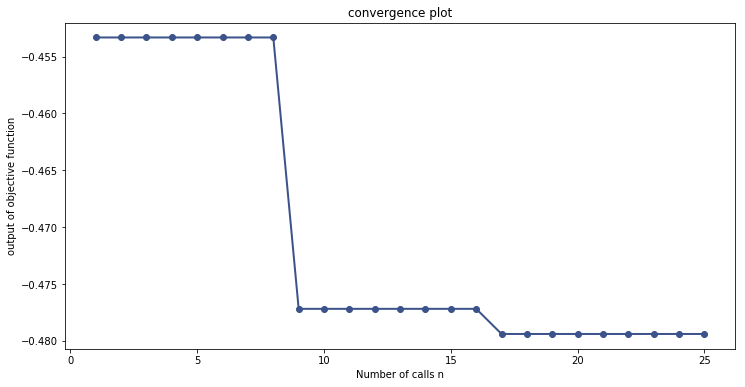

In [22]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plot_convergence(res_gp)
    plt.grid()
    plt.title('convergence plot')
    plt.ylabel('output of objective function')
    plt.xlabel('Number of calls n')
    plt.show()
    if saving:
        fig.savefig('cw{}_part{}_fig_bayes_opt_{}_conv_plot.svg'.format(
            coursework, part, learning_rate
        ))

/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/studenthp/anaconda2/envs/mlp/lib/python2.7/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands 

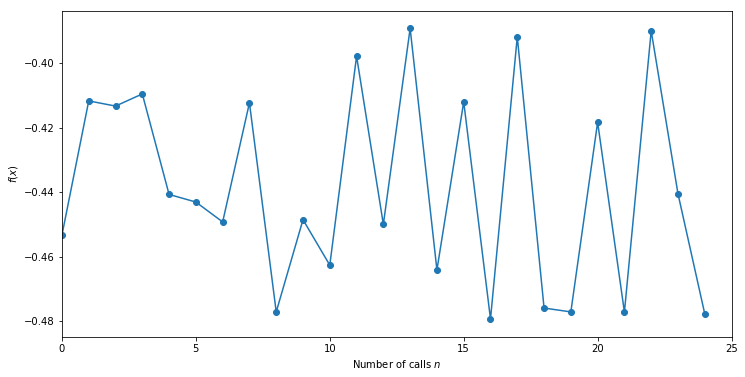

In [23]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plt.hold(True)
    plt.plot(res_gp.func_vals)
    plt.scatter(range(len(res_gp.func_vals)), res_gp.func_vals)
    plt.hold(False)
    plt.ylabel(r'$f(x)$')
    plt.xlabel('Number of calls $n$')
    plt.xlim([0, len(res_gp.func_vals)])
    plt.show()
    if saving:
        fig.savefig('cw{}_part{}_fig_bayes_opt_{}_func_val.svg'.format(
            coursework, part, learning_rate
        ))

In [24]:
statsCollection = np.load(statsCollectionFilename)[()]

/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:166: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:168: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(False)


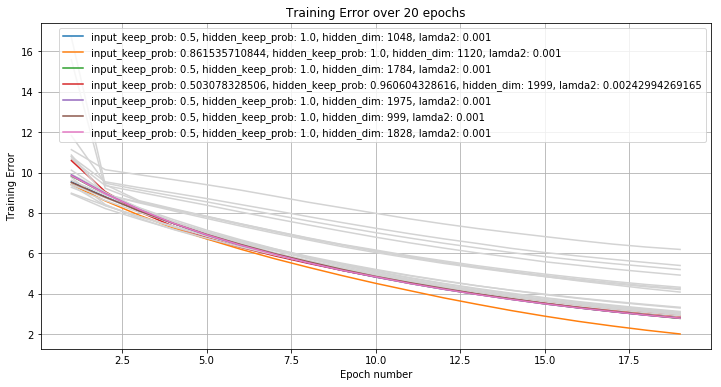

In [25]:
if plotting:
    key = "error(train)"
    fig = renderStatsCollection(statsCollection, epochs = epochs, title = "Training Error",
                          k = key, label_texts = ['input_keep_prob', 'hidden_keep_prob',
                                                 'hidden_dim', 'lamda2'])
    if saving:
        fig.savefig('cw{}_part{}_fig_bayes_opt_{}_{}.svg'.format(
            coursework, part, learning_rate, key
        ))

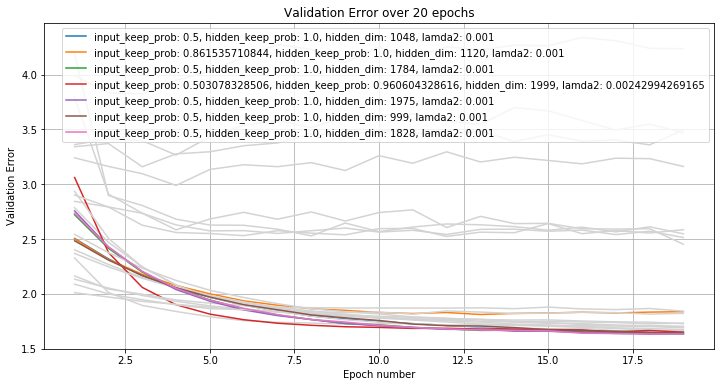

In [26]:
if plotting:
    key = "error(valid)"
    fig = renderStatsCollection(statsCollection, epochs = epochs,
                                title = "Validation Error",
                                k = key, label_texts = [
                                    'input_keep_prob', 'hidden_keep_prob',
                                                 'hidden_dim', 'lamda2'])
    if saving:
        fig.savefig('cw{}_part{}_fig_bayes_opt_{}_{}.svg'.format(
            coursework, part, learning_rate, key
        ))

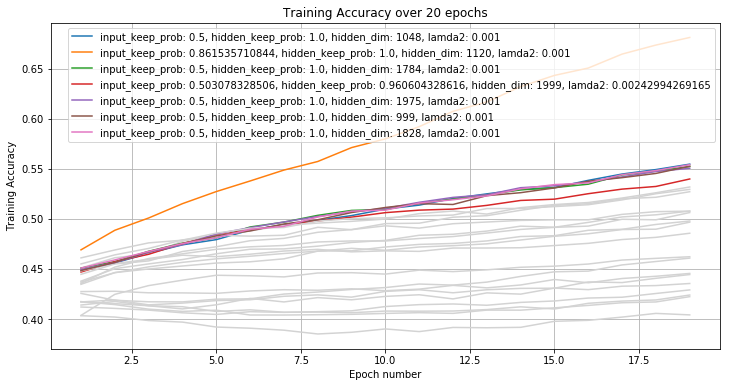

In [27]:
if plotting:
    key = "acc(train)"
    fig = renderStatsCollection(statsCollection, epochs = epochs, title = "Training Accuracy",
                          k = key, label_texts = ['input_keep_prob', 'hidden_keep_prob',
                                                 'hidden_dim', 'lamda2'])
    if saving:
        fig.savefig('cw{}_part{}_fig_bayes_opt_{}_{}.svg'.format(
            coursework, part, learning_rate, key
        ))

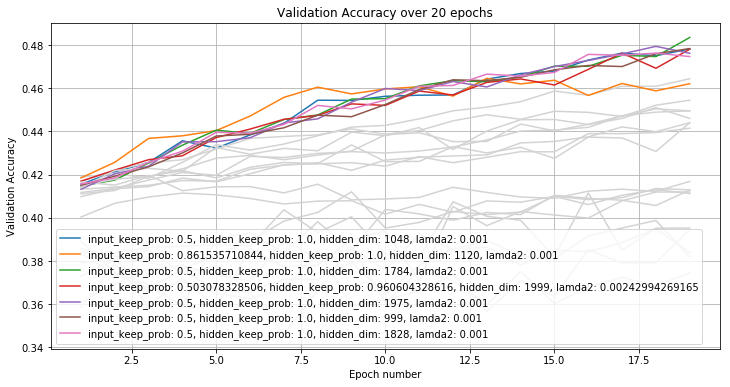

In [28]:
if plotting:
    key = "acc(valid)"
    fig = renderStatsCollection(statsCollection, epochs = epochs, title = "Validation Accuracy",
                          k = key, label_texts = ['input_keep_prob', 'hidden_keep_prob',
                                                 'hidden_dim', 'lamda2'])
    if saving:
        fig.savefig('cw{}_part{}_fig_bayes_opt_{}_{}.svg'.format(
            coursework, part, learning_rate, key
        ))

### Running full training of shallow neural net

lamda2: 0.001000
hidden dim: 1784
learning rate: 0.000100
epochs: 100
input_keep_prob: 0.500000
hidden_keep_prob: 1.000000
the inputs have 50000 length and the targets have 50000 length
End epoch 01 (49.276 secs):err(train)=10.87,acc(train)=0.42,err(valid)=3.12,acc(valid)=0.40, 
End epoch 02 (48.928 secs):err(train)=9.83,acc(train)=0.45,err(valid)=2.72,acc(valid)=0.42, 
End epoch 03 (48.839 secs):err(train)=8.95,acc(train)=0.46,err(valid)=2.42,acc(valid)=0.42, 
End epoch 04 (49.073 secs):err(train)=8.18,acc(train)=0.47,err(valid)=2.20,acc(valid)=0.43, 
End epoch 05 (48.950 secs):err(train)=7.50,acc(train)=0.48,err(valid)=2.06,acc(valid)=0.43, 
End epoch 06 (48.982 secs):err(train)=6.92,acc(train)=0.48,err(valid)=1.95,acc(valid)=0.44, 
End epoch 07 (48.923 secs):err(train)=6.41,acc(train)=0.49,err(valid)=1.86,acc(valid)=0.44, 
End epoch 08 (48.960 secs):err(train)=5.95,acc(train)=0.49,err(valid)=1.81,acc(valid)=0.45, 
End epoch 09 (48.962 secs):err(train)=5.53,acc(train)=0.50,err(valid)

/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:74: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_1.hold(True)
/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:78: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_1.hold(False)
/home/studenthp/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical/mylibs/jupyter_notebook_helper.py:87: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax_2.hold(True)
/home/studenthp/pligor.george@gma

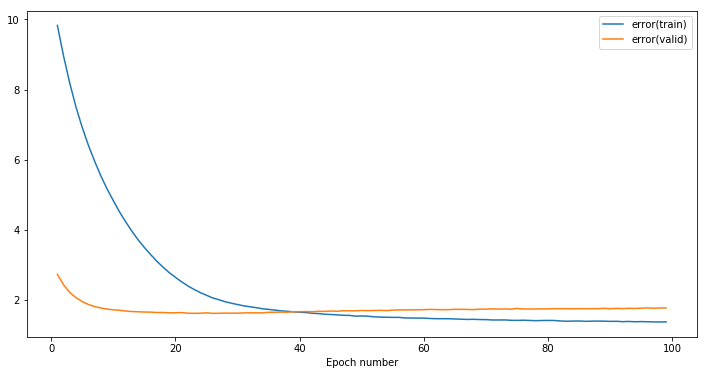

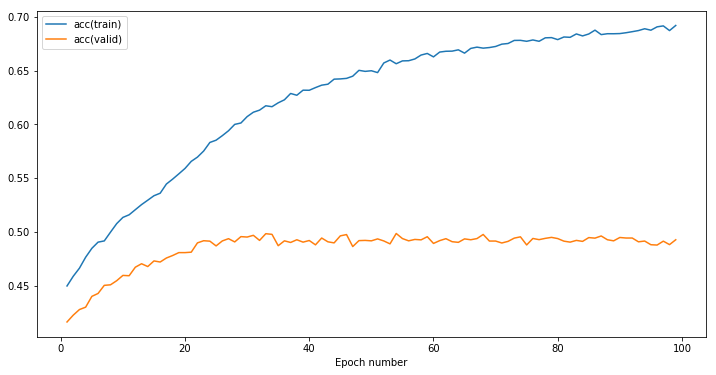

In [30]:
input_keep_prob, hidden_keep_prob, hidden_dim, lamda2 = best_params_student_teacher
hidden_dim = int(hidden_dim)

epochs = 100

studentNN = StudentNN(batch_size=batch_size, rng=rng, dtype=curDtype, config=config)

stats, keys = studentNN.teach_student(
    hidden_dim = hidden_dim,
    lamda2 = lamda2,
    learning_rate = float(learning_rate),
    epochs = epochs,
    input_keep_prob = input_keep_prob,
    hidden_keep_prob = hidden_keep_prob,
    dataset_filename = dataset_filename,
    logits_filename = logits_filename,
)

if plotting:
    fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
    plt.show()
    if saving:
        fig_1.savefig('cw{}_part{}_fig_{}_error.svg'.format(
            coursework, part, learning_rate
        ))
        fig_2.savefig('cw{}_part{}_fig_{}_acc.svg'.format(
            coursework, part, learning_rate
        ))

## TESTING